### ANALISIS 001 DE NTHUDDD

In [45]:
import numpy as np
import os
import pandas as pd
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
import lightgbm as lgb
from joblib import load, dump
from sklearn.metrics import classification_report
from itertools import chain, combinations

metricas_analisis = [
    "frame_count", "perclos", "mean_ear", "current_time_closed_eyes", "blinks_per_minute",
    "yawns_per_minute", "head_nods_per_minute", "mean_blink_time", "head_nod", "yawn", "open_eyes", "drowsiness",
    "ear", "pitch", "yaw", "mar"
]
source_folder = "NTHUDDD_dataset2_step2_600/"
train_path = f"{source_folder}train/"
test_path = f"{source_folder}test/"
label = "drowsiness"
train_df_list = []
test_df_list = []
for filename in os.listdir(train_path):
    if "night" not in filename:
        file = os.path.join(train_path, filename)
        if os.path.isfile(file) and filename[-4:] == ".csv" and filename != "big_df.csv":
            df = pd.read_csv(file)[metricas_analisis]

            file_data = filename.split("_")
            df["subject"] = filename[:3]
            df["scenario"] = file_data[1]
            df["state"] = file_data[2][:-4]
            df["id"] = df['subject'] + df['scenario'] + df['state']
            train_df_list.append(df)

for filename in os.listdir(test_path):
    if "night" not in filename:
        file = os.path.join(test_path, filename)
        if os.path.isfile(file) and filename[-4:] == ".csv" and filename != "big_df.csv":
            df = pd.read_csv(file)[metricas_analisis]
            
            file_data = filename.split("_")
            df["subject"] = filename[:3]
            df["scenario"] = file_data[1]
            df["state"] = file_data[2][:-4]
            df["id"] = df['subject'] + df['scenario'] + df['state']
            test_df_list.append(df)
train_big_df = pd.concat(train_df_list)
test_big_df = pd.concat(test_df_list)
# big_df = big_df.drop("Unnamed: 0.1", axis=1)
# train_big_df.head()
test_big_df.head()

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'NTHUDDD_dataset2_step_600/train/'

In [44]:
# train_big_df.to_csv("NTHUDDD_dataset2/big_df.csv")

In [9]:
filtered_train_big_df = train_big_df.copy()
filtered_test_big_df = test_big_df.copy()
# filtered_train_big_df = filtered_train_big_df[filtered_train_big_df["frame_count"] > 200]
filtered_train_big_df = filtered_train_big_df[filtered_train_big_df["scenario"] == "noglasses"]
filtered_train_big_df = filtered_train_big_df[filtered_train_big_df["subject"].isin(["001", "008", "009", "013", "023", "034", "035", "036"]) ]
# filtered_big_df = filtered_big_df[filtered_big_df["subject"].isin(["011"]) ]

# filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["frame_count"] > 200]
filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["scenario"] == "noglasses"]
# filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["subject"].isin(["011", "016", "021"])]
# filtered_test_big_df = filtered_test_big_df[filtered_test_big_df["subject"].isin(["003", "010", "011", "014", "016", "017", "018", "019", "021", "025", "027", "028", "029", "037"])]
filtered_train_big_df.groupby(["subject", label]).mean()

frame_count   perclos  mean_ear  current_time_closed_eyes  \
subject drowsiness                                                              
001     0           1052.102407  0.169122  0.230323                  0.039119   
        1           1276.309729  0.343809  0.243348                  0.731075   
008     0           1074.674378  0.055559  0.215494                  0.022363   
        1           1427.010122  0.274989  0.290838                  0.941437   
009     0           1074.377161  0.112762  0.267115                  0.076828   
        1           1379.420230  0.458210  0.296821                  1.627446   
013     0           1177.155239  0.098367  0.192082                  0.049026   
        1           1413.869310  0.318778  0.265582                  0.510348   
023     0           1077.808516  0.184413  0.206010                  0.209900   
        1           1362.197501  0.358286  0.255342                  0.598745   
034     0           1040.969997  0.104189  0.199750                  0.028838   
        1           1510.687126  0.208818  0.295333                  0.156189   
035     0           1069.825975  0.053482  0.132989                  0.010087   
        1           1394.054435  0.399836  0.214993                  1.873746   
036     0           1141.401877  0.142266  0.204683                  0.011718   
        1           1377.280821  0.422461  0.213860                  1.260380   

                    blinks_per_minute  yawns_per_minute  head_nods_per_minute  \
subject drowsiness                                                              
001     0                   11.135941          0.000000              0.545059   
        1                    9.983030          0.000000              0.402034   
008     0                    4.635115          0.111305              0.392842   
        1                    2.055013          0.340023              1.014687   
009     0                    4.497416          0.007548              0.292184   
        1                    6.893705          0.436376              0.611570   
013     0                    5.443380          0.000000              0.064462   
        1                    5.627489          0.549252              0.421237   
023     0                    6.794996          0.000000              0.000000   
        1                    4.996233          0.725227              0.547603   
034     0                    7.623205          0.000000              0.330589   
        1                    7.964287          0.322563              0.595789   
035     0                    4.189456          0.000000              0.000000   
        1                    1.598734          0.852056              0.660435   
036     0                    7.696385          0.165165              0.632028   
        1                    6.311624          0.498058              0.833098   

                    mean_blink_time       ear       pitch        yaw       mar  
subject drowsiness                                                              
001     0                  0.315423  0.270733   95.105396  30.991209  0.029138  
        1                  0.785776  0.205822   91.559326  29.649814  0.047850  
008     0                  0.135266  0.260461   80.395814  17.201944  0.072049  
        1                  2.066750  0.205851   79.740488  17.630816  0.155949  
009     0                  0.399340  0.336087   90.288918  23.802120  0.043205  
        1                  1.462626  0.227502   86.542689  22.045594  0.108391  
013     0                  0.254354  0.233763  108.653024  23.235451  0.059071  
        1                  1.219031  0.198388   97.258489  27.225487  0.102830  
023     0                  0.463610  0.251198   95.184977  23.005551  0.014084  
        1                  1.539379  0.208275   84.453754  15.186149  0.081117  
034     0                  0.212788  0.277625   92.282712  34.190768  0.143666  
        1                  0.567943  0.236052   8

#### NUM NULL ROWS

In [10]:
print(f"TOTAL NUM ROWS: {filtered_train_big_df.shape[0]}")
print(f"NUM NULL ROWS: {filtered_train_big_df.shape[0] - filtered_train_big_df.dropna().shape[0]}")
train_big_df_nonull = filtered_train_big_df.dropna().sample(frac=1)
train_big_df_nonull["open_eyes"] = train_big_df_nonull["open_eyes"].astype("int")
train_big_df_nonull["head_nod"] = train_big_df_nonull["head_nod"].astype("int")
train_big_df_nonull["yawn"] = train_big_df_nonull["yawn"].astype("int")


print(f"TOTAL NUM ROWS: {filtered_test_big_df.shape[0]}")
print(f"NUM NULL ROWS: {filtered_test_big_df.shape[0] - filtered_test_big_df.dropna().shape[0]}")
test_big_df_nonull = filtered_test_big_df.dropna().sample(frac=1)
test_big_df_nonull["open_eyes"] = test_big_df_nonull["open_eyes"].astype("int")
test_big_df_nonull["head_nod"] = test_big_df_nonull["head_nod"].astype("int")
test_big_df_nonull["yawn"] = test_big_df_nonull["yawn"].astype("int")

TOTAL NUM ROWS: 79534
NUM NULL ROWS: 2549
TOTAL NUM ROWS: 127047
NUM NULL ROWS: 5230


#### Experimento 1: Exploracion del mejor conjunto de metricas

La idea es construir el experimento para que con una simple ejecución obtengamos un modelo por cada posible combinacion de metricas y sus respectivos resultados.

In [31]:
metricas_posibles = [
    "perclos", "current_time_closed_eyes", "ear", "mar", "pitch",
    "yawns_per_minute", "head_nods_per_minute", "mean_blink_time"
]
experiment = False
tamano_minimo_combinacion = 3
tipo_modelo = "lgb"
experiment_folder = "model_experiments/experiment1/"
numero_metricas = len(metricas_posibles)
performance_results = []

combinacion_metricas = list(chain.from_iterable(combinations(metricas_posibles, size) for size in range(tamano_minimo_combinacion, numero_metricas + 1)))

In [6]:
if experiment:
    for ind, combinacion in enumerate(combinacion_metricas):
        print(ind)
        # model_features = ["mean_blink_time", "perclos", "current_time_closed_eyes", "yawns_per_minute", "head_nods_per_minute"]
        model_features = list(combinacion)
        x_train = train_big_df_nonull[model_features]
        y_train = train_big_df_nonull[label]
        x_test = test_big_df_nonull[model_features]
        y_test = test_big_df_nonull[label]
        
        if tipo_modelo == "lgb":
            model = lgb.LGBMClassifier(
                boosting_type="dart",
                num_leaves=400,
                num_iterations=1000,
                learning_rate=0.01,
                verbosity=-1,
                #early_stopping=20,
            )
            file = os.path.join(experiment_folder, f"lgb_model_{ind}.joblib")
        elif mod == "svm":
            model = svm.SVC(kernel="linear")
            file = os.path.join(experiment_folder, f"svm_model_{ind}.joblib")
        
        model.fit(x_train, y_train)
        dump(model, file)
        y_pred = model.predict(x_train)
        train_res = classification_report(y_train, y_pred)
        y_pred2 = model.predict(x_test)
        test_res = classification_report(y_test, y_pred2)
        
        print(train_res)
        print(test_res)

        performance_results.append((model_features, train_res, test_res))

In [7]:
if experiment:
    best_accuracy = -1
    best_ind = -1
    ind = 0
    for model_features, train_res, test_res in performance_results:
        # print(test_res)
        split_test_res = test_res.split()
        # print(split_test_res)
        accuracy = float(split_test_res[15])
        if accuracy >= best_accuracy:
            best_ind = ind
            best_accuracy = accuracy
        ind += 1

    print(f"BEST_IND: {best_ind} {performance_results[best_ind][0]} --> ACC: {best_accuracy}")

#### Escribimos los resultados

In [8]:
if experiment:
    file_path = os.path.join(experiment_folder, "report.txt")
    if os.path.exists(file_path):
        os.remove(file_path)

    file = open(file_path, "a")
    for model_features, train_res, test_res in performance_results:
        file.write(f"{str(model_features)}\n")
        file.write(train_res)
        file.write(test_res)
        file.write("\n")
    file.close()

In [39]:
model_features = ["ear", "mar", "pitch", 'perclos', 'current_time_closed_eyes', 'yawns_per_minute', 'head_nods_per_minute']
x_train = train_big_df_nonull[model_features]
y_train = train_big_df_nonull[label]
x_test = test_big_df_nonull[model_features]
y_test = test_big_df_nonull[label]
# test_size = len(labels)
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

In [40]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train)

x_train_normalized = min_max_scaler.transform(x_train)
x_test_normalized = min_max_scaler.transform(x_test)

In [62]:
scaler = StandardScaler()
print(scaler.fit(x_train))
print(scaler.mean_)

x_train_transformed = scaler.transform(x_train)
x_test_transformed = scaler.transform(x_test)

StandardScaler()
[ 0.29920751  0.13854677 90.51895971  0.25418981  0.60091314  0.38208252
  0.2798355 ]


In [41]:
data_type = ""
x_train_data = x_train
x_test_data = x_test 
if data_type == "normalized":
    x_train_data = x_train_normalized
    x_test_data = x_test_normalized
elif data_type == "standardized":
    x_train_data = x_train_transformed
    x_test_data = x_test_normalized

mod = "lgb"
if mod == "lgb":
    model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=1820,
        num_iterations=1000,
        n_estimators=10000,
        max_depth=9,
        min_data_in_leaf=200,
        lambda_l1=100,
        lambda_l2=50,
        min_split_gain=6.23386152668858,
        bagging_fraction=0.2,
        baggin_freq=1,
        feature_fraction=0.9,
        learning_rate=0.2877383794743792,
        verbosity=-1,
        #early_stopping=20,
    )
    file = "lgb_models/lgb_model_0.joblib"
elif mod == "svm":
    model = svm.SVC(kernel="linear")
    file = "svm_model_0.joblib"
elif mod == "knn":
    model = KNeighborsClassifier(n_neighbors=30)
    file = "knn_model_0.joblib"
elif mod == "reg":
    model = LogisticRegression(random_state=0, solver="saga", penalty="elasticnet", l1_ratio=0)
    file = "logreg_model_0.joblib"

# eval_set=[(x_test_data, y_test)], callbacks=[lgb.early_stopping(stopping_rounds=5)]
model.fit(x_train_data, y_train)
dump(model, file)
y_pred = model.predict(x_train_data)
print(classification_report(y_train, y_pred))
y_pred2 = model.predict(x_test_data)
print(classification_report(y_test, y_pred2))

c:\Users\adrim\.conda\envs\TFG\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: baggin_freq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     31172
           1       0.92      0.93      0.92     45813

    accuracy                           0.91     76985
   macro avg       0.90      0.90      0.90     76985
weighted avg       0.91      0.91      0.91     76985

              precision    recall  f1-score   suppo

In [95]:
print(y_pred2)

[0 1 0 ... 1 0 1]


In [23]:
optuna_model = load("lgb_model_optuna.joblib")
y_pred_proba = np.transpose(model.predict_proba(x_test))
print(y_pred_proba)
# y_pred = [ 0 if x0 > 0.5 else 1 for x0, x1 in y_pred_proba ]

[[0.02005811 0.61185665 0.84573054 ... 0.28139623 0.93196724 0.88563984]
 [0.97994189 0.38814335 0.15426946 ... 0.71860377 0.06803276 0.11436016]]


In [22]:
# y_pred2 = model.predict(x_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     69824
           1       0.79      0.92      0.85     51993

    accuracy                           0.86    121817
   macro avg       0.86      0.87      0.86    121817
weighted avg       0.87      0.86      0.86    121817



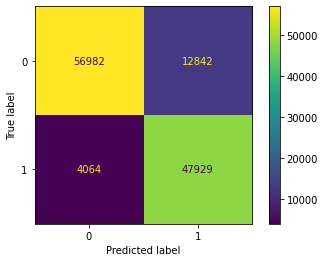

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred2)

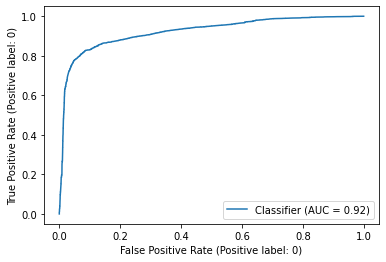

In [25]:
RocCurveDisplay.from_predictions(y_test, y_pred_proba[0], pos_label=0)

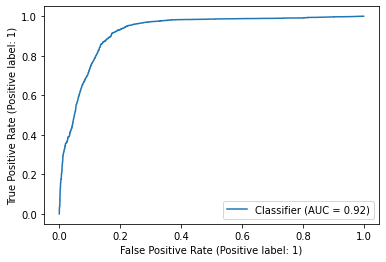

In [26]:
RocCurveDisplay.from_predictions(y_test, y_pred_proba[1], pos_label=1)

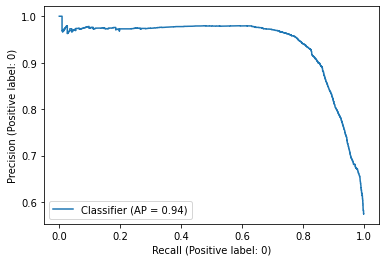

In [27]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[0], pos_label=0)

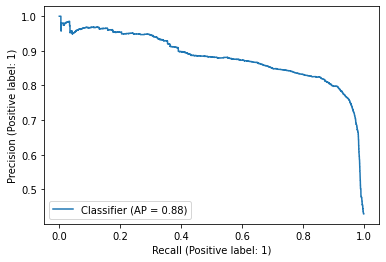

In [28]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[1], pos_label=1)

In [ ]:
import shap
import numpy as np
from joblib import load
model = load("lgb_models/lgb_model_0.joblib")
previous_model = load("lgb_model_003.joblib")
explainer = shap.TreeExplainer(model)

In [32]:
y_pred2 = model.predict(x_test)
print(classification_report(y_test, y_pred2))

In [ ]:
row = 1311
pd_df = np.asarray(x_test.iloc[[row]])
# pd_df = np.array([[0.24, 0.08, (2/30), 0.0, 0]])
shap_values = explainer.shap_values(pd_df)
expected_value = explainer.expected_value

shap_values0 = shap_values[0]
shap_values1 = shap_values[1]
expected_value0 = expected_value[0]
expected_value1 = expected_value[1]

print(np.asarray(y_test.iloc[[row]]))
print(model.predict(pd_df))
print(shap_values)
print(expected_value)

In [ ]:
print(x_test.columns)
print(pd_df)
shap.summary_plot(shap_values0, features=pd_df, feature_names=x_test.columns, plot_type="dot")

In [ ]:
shap.decision_plot(expected_value0, shap_values0, features=pd_df, feature_names=list(x_test.columns))

#### Analisis error del modelo

In [10]:
test_big_df_nonull.groupby(["subject", label]).mean()[metricas_posibles]

NameError: name 'metricas_posibles' is not defined

In [29]:
# join test_data and predictions

test_with_preds_labels = test_big_df_nonull.copy()
test_with_preds_labels["pred"] = y_pred2
test_with_preds_labels["hit"] = test_with_preds_labels["pred"] == test_with_preds_labels[label]

print(test_with_preds_labels[label])
print(y_test)

test_with_preds_labels.groupby(["id", label])[["hit"]].mean()

10029    1
11209    0
9747     0
6764     1
14548    1
        ..
15150    1
4509     1
1888     1
1831     0
11616    0
Name: drowsiness, Length: 121817, dtype: int64
10029    1
11209    0
9747     0
6764     1
14548    1
        ..
15150    1
4509     1
1888     1
1831     0
11616    0
Name: drowsiness, Length: 121817, dtype: int64


hit
id              drowsiness          
003noglassesmix 0           0.939464
                1           0.824731
010noglassesmix 0           0.354267
011noglassesmix 0           0.832327
014noglassesmix 0           0.895349
                1           0.692451
016noglassesmix 0           0.966550
                1           0.739920
017noglassesmix 0           0.934459
                1           0.998459
018noglassesmix 0           0.798420
                1           0.986134
019noglassesmix 0           0.859913
                1           0.998039
021noglassesmix 0           0.914758
                1           0.964297
025noglassesmix 0           0.998298
027noglassesmix 0           0.798985
                1           0.981378
028noglassesmix 0           0.460324
029noglassesmix 0           0.289892
                1           0.995182
037noglassesmix 0           1.000000
                1           0.972098

#### Optuna hiperparameter tuning

In [ ]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
def train_lgb_optuna(x_train, y_train, x_test, y_test, features, save=False):
    def objective(trial, x_train, y_train, x_test, y_test):
        param_grid = {
            "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_categorical("n_estimators", [1000, 10000, 100000]),
            "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 40),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
            "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
            "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 25),
            "bagging_fraction": trial.suggest_float(
                "bagging_fraction", 0.2, 0.95, step=0.1
            ),
            "bagging_freq": trial.suggest_categorical("bagging_freq", [1, 2, 3]),
            "feature_fraction": trial.suggest_float(
                "feature_fraction", 0.2, 0.95, step=0.1
            ),
        }

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            x_train,
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=300,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(x_test)
        score = log_loss(y_test, preds)
        print(score)
        return score

    study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
    func = lambda trial: objective(trial, x_train, y_train, x_test, y_test)
    study.optimize(func, n_trials=300)

    best_params = {
        "objective": "binary",
        "metric": "accuracy",
        "verbosity": -1,
        "boosting_type": "dart",
        "seed": 42
    } 
    best_params.update(study.best_params)
    print(f"\tBest value (binary_logloss): {study.best_value:.5f}")
    print(f"\tBest params:")

    for key, value in best_params.items():
        print(f"\t\t{key}: {value}")
    
    # x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

    train_dataset = lgb.Dataset(
        data=x_train,
        label=y_train,
    )
    lgb_model = lgb.train(best_params,
                          train_dataset,
                          num_boost_round=4000,
                          ) 

    y_pred = [round(pred) for pred in lgb_model.predict(x_train)]
    print(classification_report(y_train, y_pred))  
    y_pred = [round(pred) for pred in lgb_model.predict(x_test)]
    print(classification_report(y_test, y_pred))   

    if save:
        dump(lgb_model, "lgb_model_optuna.joblib")
    return lgb_model

In [ ]:
train_lgb_optuna(x_train, y_train, x_test, y_test, [], save=True)

In [32]:
train_big_df_nonull.groupby(["subject", label]).mean()[metricas_posibles + ["open_eyes", "head_nod", "yawn"]]

perclos  current_time_closed_eyes       ear       mar  \
subject drowsiness                                                           
001     0           0.169122                  0.039119  0.270733  0.029138   
        1           0.343809                  0.731075  0.205822  0.047850   
008     0           0.055559                  0.022363  0.260461  0.072049   
        1           0.274989                  0.941437  0.205851  0.155949   
009     0           0.112762                  0.076828  0.336087  0.043205   
        1           0.458210                  1.627446  0.227502  0.108391   
013     0           0.098367                  0.049026  0.233763  0.059071   
        1           0.318778                  0.510348  0.198388  0.102830   
023     0           0.184413                  0.209900  0.251198  0.014084   
        1           0.358286                  0.598745  0.208275  0.081117   
034     0           0.104189                  0.028838  0.277625  0.143666   
        1           0.208818                  0.156189  0.236052  0.173632   
035     0           0.053482                  0.010087  0.300257  0.077446   
        1           0.399836                  1.873746  0.172436  0.231257   
036     0           0.142266                  0.011718  0.249570  0.084301   
        1           0.422461                  1.260380  0.156210  0.128870   

                         pitch  yawns_per_minute  head_nods_per_minute  \
subject drowsiness                                                       
001     0            95.105396          0.000000              0.545059   
        1            91.559326          0.000000              0.402034   
008     0            80.395814          0.111305              0.392842   
        1            79.740488          0.340023              1.014687   
009     0            90.288918          0.007548              0.292184   
        1            86.542689          0.436376              0.611570   
013     0           108.653024          0.000000              0.064462   
        1            97.258489          0.549252              0.421237   
023     0            95.184977          0.000000              0.000000   
        1            84.453754          0.725227              0.547603   
034     0            92.282712          0.000000              0.330589   
        1            87.432404          0.322563              0.595789   
035     0            99.775012          0.000000              0.000000   
        1            94.272900          0.852056              0.660435   
036     0            89.654757          0.165165              0.632028   
        1            85.317356          0.498058              0.833098   

                    mean_blink_time  open_eyes  head_nod      yawn  
subject drowsiness                                                  
001     0                  0.315423   0.837942  0.020225  0.000000  
        1                  0.785776   0.622913  0.106697  0.000000  
008     0                  0.135266   0.936272  0.010694  0.000000  
        1                  2.066750   0.667494  0.102559  0.163484  
009     0                  0.399340   0.875578  0.013392  0.000000  
        1                  1.462626   0.508264  0.053360  0.091089  
013     0                  0.254354   0.898117  0.017866  0.000000  
        1                  1.219031   0.626575  0.075592  0.094406  
023     0                  0.463610   0.789209  0.000000  0.000000  
        1                  1.539379   0.595627  0.088858  0.086428  
034     0                  0.212788   0.875034  0.002753  0.000000  
        1                  0.567943   0.763887  0.032713  0.094899  
035     0                  0.154175   0.946421  0.000000  0.000000  
        1                  3.773286   0.546378  0.170852  0.243577  
036     0                  0.376139   0.918515  0.006399  0.000000  
        1                  1.491189   0.437164  0.156144  0.146385